In [1]:
import findspark
findspark.init('/home/sdmohant/spark-3.0.0-bin-hadoop2.7')

In [2]:
import pyspark
from pyspark import SparkContext,SparkConf

In [3]:
from pyspark.sql import SparkSession

In [4]:
#spark = SparkSession.builder.appName("MyApp").getOrCreate()
#spark = SparkSession.builder.appName("MyName").getOrCreate()
conf = SparkConf().set("spark.cores.max", "16") \
    .set("spark.driver.memory", "16g") \
    .set("spark.executor.memory", "16g") \
    .set("spark.executor.memory_overhead", "16g") \
    .set("spark.driver.maxResultsSize", "0") \
    .set("spark.sql.shuffle.partitions","300")

sc = SparkContext(appName="envsciencemodel", conf=conf)
spark = SparkSession(sc)

/home/sdmohant/spark-3.0.0-bin-hadoop2.7/python/pyspark/context.py:220: DeprecationWarning: Support for Python 2 and Python 3 prior to version 3.6 is deprecated as of Spark 3.0. See also the plan for dropping Python 2 support at https://spark.apache.org/news/plan-for-dropping-python-2-support.html.
  DeprecationWarning)


In [5]:
from pyspark.sql.functions import isnan, count, col, when

In [6]:
envscienceFOSID = 39432304

In [14]:
papers = spark.read.options(header = True, inferSchema = True,delimiter=',').csv("AllPapersFOS1.csv")

In [17]:
papers_filtered = papers.filter(col('FOS_ID').isin(['39432304']))

In [18]:
type(papers_filtered)

pyspark.sql.dataframe.DataFrame

In [19]:
papers_filtered.count()

35780

In [36]:
papers_pd = papers_filtered.toPandas()

In [37]:
papers_pd.head()

,PaperID,Rank,PaperYear,Volume,Issue,ReferenceCount,CitationCount,EstimatedCount,FOS_ID,PaperAge,IsJournal,min_FOSRank,max_FOSRank,max_FOSPaperCount,min_FOSPaperCount,min_FOSCitationCount,max_FOSCitationCount,PaperRefCnt
0,7947795,23352,1964,0,0,0,22,22,39432304,56,1,8436,12935,1830253,81162,338871,6506374,0
1,57879122,25330,2014,0,0,0,0,0,39432304,6,1,8436,10284,1830253,37168,216494,6506374,0
2,87903810,23667,1975,254,5497,0,0,0,39432304,45,0,8188,11856,1830253,2825,10036,34103285,0
3,88768105,25658,2011,0,0,0,0,0,39432304,9,1,8436,12623,1830253,88590,159405,6506374,0
4,92491293,30666,1963,0,0,0,0,0,39432304,57,1,8436,10775,1830253,621643,4556314,6506374,0


In [38]:
papers_pd.rename(columns = {'CitationCount':'label'}, inplace = True)

In [39]:
papers_pd.columns

Index([u'PaperID', u'Rank', u'PaperYear', u'Volume', u'Issue',
       u'ReferenceCount', u'label', u'EstimatedCount', u'FOS_ID', u'PaperAge',
       u'IsJournal', u'min_FOSRank', u'max_FOSRank', u'max_FOSPaperCount',
       u'min_FOSPaperCount', u'min_FOSCitationCount', u'max_FOSCitationCount',
       u'PaperRefCnt'],
      dtype='object')

In [56]:
papers_pd_new = papers_pd.drop(["PaperID","EstimatedCount","PaperYear","Issue","Volume","FOS_ID"],axis=1)

In [57]:
papers_pd_new.columns

Index([u'Rank', u'ReferenceCount', u'label', u'PaperAge', u'IsJournal',
       u'min_FOSRank', u'max_FOSRank', u'max_FOSPaperCount',
       u'min_FOSPaperCount', u'min_FOSCitationCount', u'max_FOSCitationCount',
       u'PaperRefCnt'],
      dtype='object')

In [58]:
papers_pd_new = papers_pd_new.reindex(columns=['Rank','ReferenceCount','PaperAge','min_FOSRank','max_FOSRank','IsJournal','max_FOSPaperCount',\
                               'min_FOSPaperCount','min_FOSCitationCount','max_FOSCitationCount','PaperRefCnt','label'])

In [59]:
papers_pd_new.head()

,Rank,ReferenceCount,PaperAge,min_FOSRank,max_FOSRank,IsJournal,max_FOSPaperCount,min_FOSPaperCount,min_FOSCitationCount,max_FOSCitationCount,PaperRefCnt,label
0,23352,0,56,8436,12935,1,1830253,81162,338871,6506374,0,22
1,25330,0,6,8436,10284,1,1830253,37168,216494,6506374,0,0
2,23667,0,45,8188,11856,0,1830253,2825,10036,34103285,0,0
3,25658,0,9,8436,12623,1,1830253,88590,159405,6506374,0,0
4,30666,0,57,8436,10775,1,1830253,621643,4556314,6506374,0,0


In [60]:
len(papers_pd_new.columns)

12

In [61]:
X = papers_pd_new.iloc[:, 0:11].values
y = papers_pd_new.iloc[:, 11].values

In [62]:
X[0:5]

array([[   23352,        0,       56,     8436,    12935,        1,
         1830253,    81162,   338871,  6506374,        0],
       [   25330,        0,        6,     8436,    10284,        1,
         1830253,    37168,   216494,  6506374,        0],
       [   23667,        0,       45,     8188,    11856,        0,
         1830253,     2825,    10036, 34103285,        0],
       [   25658,        0,        9,     8436,    12623,        1,
         1830253,    88590,   159405,  6506374,        0],
       [   30666,        0,       57,     8436,    10775,        1,
         1830253,   621643,  4556314,  6506374,        0]], dtype=int32)

In [63]:
from sklearn.model_selection import KFold

In [64]:
kf = KFold(n_splits=5)
kf.get_n_splits(X, y)

5

In [65]:
from sklearn.ensemble import RandomForestRegressor
import numpy as np

In [67]:
from sklearn.metrics import mean_squared_error
from sklearn import metrics

In [68]:
rmse_list = []
for train_index, test_index in kf.split(X,y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    regressor = RandomForestRegressor(n_estimators=100, max_depth=30, random_state=0)
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)
    rmse_list.append(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
    print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    

('Mean Absolute Error:', 1.9500956719040452)
('Mean Squared Error:', 923.9964595634815)
('Root Mean Squared Error:', 30.397310071180335)
('Mean Absolute Error:', 1.6542599062085788)
('Mean Squared Error:', 206.88588466663666)
('Root Mean Squared Error:', 14.38352824124306)
('Mean Absolute Error:', 2.1681637969884235)
('Mean Squared Error:', 1070.4210758909849)
('Root Mean Squared Error:', 32.717290167295104)
('Mean Absolute Error:', 2.2055272184693617)
('Mean Squared Error:', 2180.710986753475)
('Root Mean Squared Error:', 46.69808333061942)
('Mean Absolute Error:', 1.3230572427010467)
('Mean Squared Error:', 51.94662605186229)
('Root Mean Squared Error:', 7.207400783351949)


In [69]:
rmse_sum = 0
for index in range(0,5):
    rmse_sum = rmse_sum + rmse_list[index]
mean_rmse = rmse_sum/5
print("Mean RMSE is :",mean_rmse)

('Mean RMSE is :', 26.280722518737974)


## Comparison with Microsoft Estimations

In [70]:
y_est = np.array(papers_pd["EstimatedCount"])
y_act = np.array(papers_pd["label"])

In [71]:
print('Mean Absolute Error of EstimatedCount:', metrics.mean_absolute_error(y_act, y_est))
print('Mean Squared Error of EstimatedCount:', metrics.mean_squared_error(y_act, y_est))
print('Root Mean Squared of with EstimatedCount:', np.sqrt(metrics.mean_squared_error(y_act, y_est)))

('Mean Absolute Error of EstimatedCount:', 1.9495807713806597)
('Mean Squared Error of EstimatedCount:', 3931.573784237004)
('Root Mean Squared of with EstimatedCount:', 62.70226299135466)


In [72]:
import xgboost as xgb

In [73]:
from sklearn.model_selection import train_test_split

In [77]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.33)

In [78]:
regressor = xgb.XGBRegressor(
    n_estimators=150,
    reg_lambda=1,
    gamma=0,
    max_depth=30
)

In [79]:
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
np.sqrt(metrics.mean_squared_error(y_test, y_pred))

35.75438035166671

In [80]:
kf = KFold(n_splits=5)
kf.get_n_splits(X)

5

In [81]:
rmse_list = []
for train_index, test_index in kf.split(X,y):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    regressor = xgb.XGBRegressor(
                n_estimators=100,
                reg_lambda=1,
                gamma=0,
                max_depth=40
                )
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)
    rmse_list.append(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    print('Mean Absolute Error of XGBoost Kfold:', metrics.mean_absolute_error(y_test, y_pred))
    print('Mean Squared Error of XGBoost Kfold:', metrics.mean_squared_error(y_test, y_pred))
    print('Root Mean Squared Error of XGBoost Kfold:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

('Mean Absolute Error of XGBoost Kfold:', 2.1029547167688927)
('Mean Squared Error of XGBoost Kfold:', 1144.3993246912696)
('Root Mean Squared Error of XGBoost Kfold:', 33.828971676527054)
('Mean Absolute Error of XGBoost Kfold:', 1.995200872183879)
('Mean Squared Error of XGBoost Kfold:', 523.2402574867415)
('Root Mean Squared Error of XGBoost Kfold:', 22.87444551211551)
('Mean Absolute Error of XGBoost Kfold:', 2.302791425395005)
('Mean Squared Error of XGBoost Kfold:', 951.8769340408951)
('Root Mean Squared Error of XGBoost Kfold:', 30.852502881304382)
('Mean Absolute Error of XGBoost Kfold:', 2.3225619246951026)
('Mean Squared Error of XGBoost Kfold:', 2212.337741947967)
('Root Mean Squared Error of XGBoost Kfold:', 47.03549449030984)
('Mean Absolute Error of XGBoost Kfold:', 1.4981082770546565)
('Mean Squared Error of XGBoost Kfold:', 177.64003683753728)
('Root Mean Squared Error of XGBoost Kfold:', 13.328167047180091)


In [82]:
rmse_sum = 0
for index in range(0,5):
    rmse_sum = rmse_sum + rmse_list[index]
mean_rmse = rmse_sum/5
print("Mean RMSE is :",mean_rmse)

('Mean RMSE is :', 29.58391632148738)


In [83]:
importances = regressor.feature_importances_

In [84]:
for i,v in enumerate(importances):
	print('Feature: %0d, Score: %.5f' % (i,v))

Feature: 0, Score: 0.50283
Feature: 1, Score: 0.06808
Feature: 2, Score: 0.14265
Feature: 3, Score: 0.03175
Feature: 4, Score: 0.09474
Feature: 5, Score: 0.02423
Feature: 6, Score: 0.00162
Feature: 7, Score: 0.08217
Feature: 8, Score: 0.03641
Feature: 9, Score: 0.00942
Feature: 10, Score: 0.00610


In [86]:
import pandas as pd

In [90]:
cols = papers_pd_new.columns

In [93]:
import matplotlib.pyplot as plt
%matplotlib inline

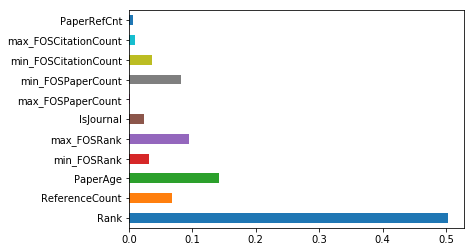

In [96]:
(pd.Series(importances, index=cols[0:11]).plot(kind='barh'))  